# Exploration - NASA JetEngine Failure Analysis

## Objective of this Notebook
- Load and explain the dataset
- Basic survival regression for the whole population of engines
  - Estimate survival rate with Kaplan-Maier and hazard with Nelson-Aaler estimators
  - Determine importance of features with survival regression

In [2]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from lifelines import KaplanMeierFitter, NelsonAalenFitter, WeibullFitter

## Our dataset
We have a fleet of **100 aircraft** engines of the **same model**. Each engine
starts with different **unknown** degrees of **initial wear** and **manufacturing
variation** which is considered normal. Each engine is **operating** at **normal
conditions** at the beginning of the time series but **degrades over time**
until a **predefined, unknown failure threshold** is reached. The **objective**
is to **predict** from any **point in time** how long we have until we need to
**perform maintenance**.

References:
* *A. Saxena, K. Goebel, D. Simon, and N. Eklund*, **“Damage Propagation
Modeling for Aircraft Engine Run-to-Failure Simulation”**, in the
Proceedings of the 1st International Conference on Prognostics and Health
Management (PHM08), Denver CO, Oct 2008.

In [6]:
id_col = 'Unit'
time_col = 'Time'
feature_cols = [
  'Setting1', 
  'Setting2', 
  'Setting3', 
  'FanInletTemp',
  'LPCOutletTemp', 
  'HPCOutletTemp', 
  'LPTOutletTemp', 
  'FanInletPres', 
  'BypassDuctPres', 
  'TotalHPCOutletPres', 
  'PhysFanSpeed', 
  'PhysCoreSpeed', 
  'EnginePresRatio', 
  'StaticHPCOutletPres', 
  'FuelFlowRatio', 
  'CorrFanSpeed', 
  'CorrCoreSpeed', 
  'BypassRatio', 
  'BurnerFuelAirRatio', 
  'BleedEnthalpy', 
  'DemandFanSpeed', 
  'DemandCorrFanSpeed', 
  'HPTCoolantBleed', 
  'LPTCoolantBleed'
]
column_names = [id_col, time_col] + feature_cols

base_path = "https://raw.githubusercontent.com/anofox/m3_konferenz/master//prepared_data/nasa_jetengine/"
train_orig = pd.read_csv(base_path + 'train.csv.gz', header=None, names=column_names)
test_x_orig = pd.read_csv(base_path + 'test_x.csv.gz', header=None, names=column_names)
test_y_orig = pd.read_csv(base_path + 'test_y.csv.gz', header=None, names=['T'])

train_orig.set_index(['Unit', 'Time'], verify_integrity=True).head()

Setting1  Setting2  Setting3  FanInletTemp  LPCOutletTemp  \
Unit Time                                                              
1    1      -0.0007   -0.0004     100.0        518.67         641.82   
     2       0.0019   -0.0003     100.0        518.67         642.15   
     3      -0.0043    0.0003     100.0        518.67         642.35   
     4       0.0007    0.0000     100.0        518.67         642.35   
     5      -0.0019   -0.0002     100.0        518.67         642.37   

           HPCOutletTemp  LPTOutletTemp  FanInletPres  BypassDuctPres  \
Unit Time                                                               
1    1           1589.70        1400.60         14.62           21.61   
     2           1591.82        1403.14         14.62           21.61   
     3           1587.99        1404.20         14.62           21.61   
     4           1582.79        1401.87         14.62           21.61   
     5           1582.85        1406.22         14.62           21.61   

           TotalHPCOutletPres       ...         FuelFlowRatio  CorrFanSpeed  \
Unit Time                           ...                                       
1    1                 554.36       ...                521.66       2388.02   
     2                 553.75       ...                522.28       2388.07   
     3                 554.26       ...                522.42       2388.03   
     4                 554.45       ...                522.86       2388.08   
     5                 554.00       ...                522.19       2388.04   

           CorrCoreSpeed  BypassRatio  BurnerFuelAirRatio  BleedEnthalpy  \
Unit Time                                                                  
1    1           8138.62       8.4195                0.03            392   
     2           8131.49       8.4318                0.03            392   
     3           8133.23       8.4178                0.03            390   
     4           8133.83       8.3682                0.03            392   
     5           8133.80       8.4294                0.03            393   

           DemandFanSpeed  DemandCorrFanSpeed  HPTCoolantBleed  \
Unit Time                                                        
1    1               2388               100.0            39.06   
     2               2388               100.0            39.00   
     3               2388               100.0            38.95   
     4               2388               100.0            38.88   
     5               2388               100.0            38.90   

           LPTCoolantBleed  
Unit Time                   
1    1             23.4190  
     2             23.4236  
     3             23.3442  
     4             23.3739  
     5             23.4044  

[5 rows x 24 columns]

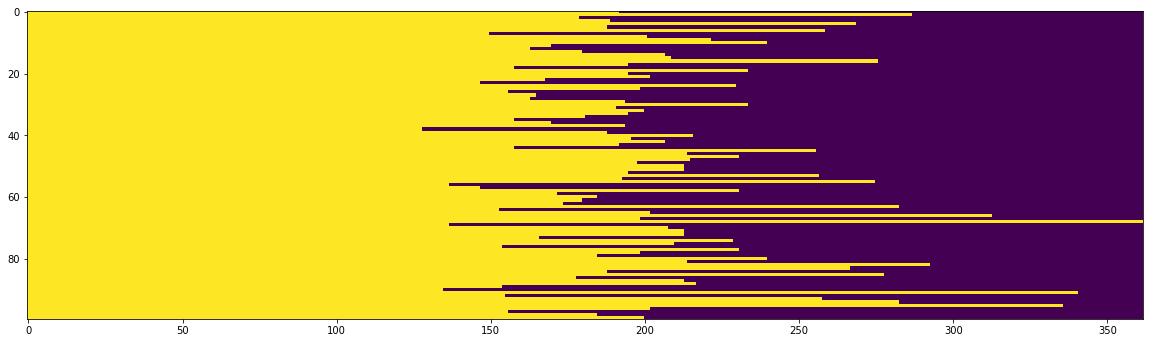

In [4]:
M = np.zeros((len(train_orig["Unit"].unique()), len(train_orig["Time"].unique())))
M[train_orig["Unit"] - 1, train_orig["Time"] - 1] = train_orig["FanInletTemp"]
plt.figure(figsize=(20, 10))
plt.imshow(M)

# Goal: Time-to-Failure
Our goal is showing a predictive maintenance case by using survival analysis theory to build a probabilistic model to predict **time to failure**. A time-to-failure model is a special case of an event model: In a time-to-failure model the single sequence will always end with the failure event, while in a time-to-event model each sequence will contain multiple target events and the goal is to estimating when the next event will happen.

# Survival analysis

![title](/notebooks/imgs/tte_visualzation.gif)

Survival analysis is a special branch of statistics, mainly applied in medicine or pharmacology. This is where the name stems from. In general survival analysis is the study of expected duration of time until one or more events happen, in our case failure in mechanical systems.

It differs from traditional regression problems because the data can be partially observed, or censored. That is, we observe a phenomenon up to a point in time where we stop collecting data either because the failure event happens and is registered (uncensored) or because it was not possible to collect data furtherly (censored) due to technical issues or because of the failure is not happened yet at current time. Typically the case is considered where data is left-censored, meaning one can always observe the beginning of the signal or events sequence The above visualization shows the time interval which is (right) censored in red.

The survival model is then characterized by either its **survival function $S(t)$** defined as the probability that a subject survives longer than time $t$; or by its cumulative **hazard function $H(t)$** which is the accumulation of hazard over time and defined by the integral between $0$ and $t$ of the probability of failing instantly at time $x$ given that it survived up to $x$.

# Statistical models for survival analysis
In literature we often find two main non-parametric estimators for fitting survival distributions. They are the **Kaplan-Maier** and **Nelson-Aaler** estimators.

The main parametric distribution used to model survival processes is the **Weibull distribution**, as it well represent the future life time in many real-word use cases. The Weibull distribution is defined as by parameters $\alpha$ and $\beta$ as such:

- Continous form:
$$ f(t) = \frac{\beta}{\alpha} \left( \frac{t}{\alpha} \right)^{\beta - 1} \exp^{-\left( \frac{t}{\alpha} \right)^{\beta}}  $$

- Discrete form:
$$ f(t) =  \exp^{-\left( \frac{t}{\alpha} \right)^{\beta}} - \exp^{-\left( \frac{t+1}{\alpha} \right)^{\beta}}  $$

The parameter $\alpha$ is an indicator of where the expected mode of the distribution is positioned in time while the $\beta$ parameter is an indicator of the variance of our prediction (the larger the less confident).

# Classical, statistical survival analysis and regression techniques
Fitting a distribution can be worth in case that we want to compare different populations, e.g. in clinic tests, and decide whether there is a statistical signficance between the different survival curves. In order to predict the time-to-failure we want to use different features as regressors and predict as output the survival function, or related functions, of each individual.

For static attributes or hand-crafted features (e.g. lags, accumulated statistics, aggregated statistics) we can use the **Cox's Proportional Hazard** model or **Aalen's Additive** model.

Both Cox's and Aalen's models are based on a non-parametric baseline of the survival function which is multiplied by another function which is a combination of the input features. Both of them do a good job on describing the variables that impact the survival of a given individual. Nevertheless, they are limited in the type of input data that can handle and suffer from low generalization due to the high degree of freedom of the non-parametric nature of the model.

In [5]:
surv_time_df = train_orig.groupby("Unit")["Time"].agg({"T_min": "min", "T_max": "max"}) \
                         .assign(T = lambda x: x.T_max - x.T_min + 1) \
                         .assign(E = True)
surv_time_df.sample(n=10)

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,T_min,T_max,T,E
Unit,,,,
37,1,170,170,True
64,1,283,283,True
53,1,195,195,True
8,1,150,150,True
63,1,174,174,True
93,1,155,155,True
19,1,158,158,True
55,1,193,193,True
21,1,195,195,True


Survival time median 199


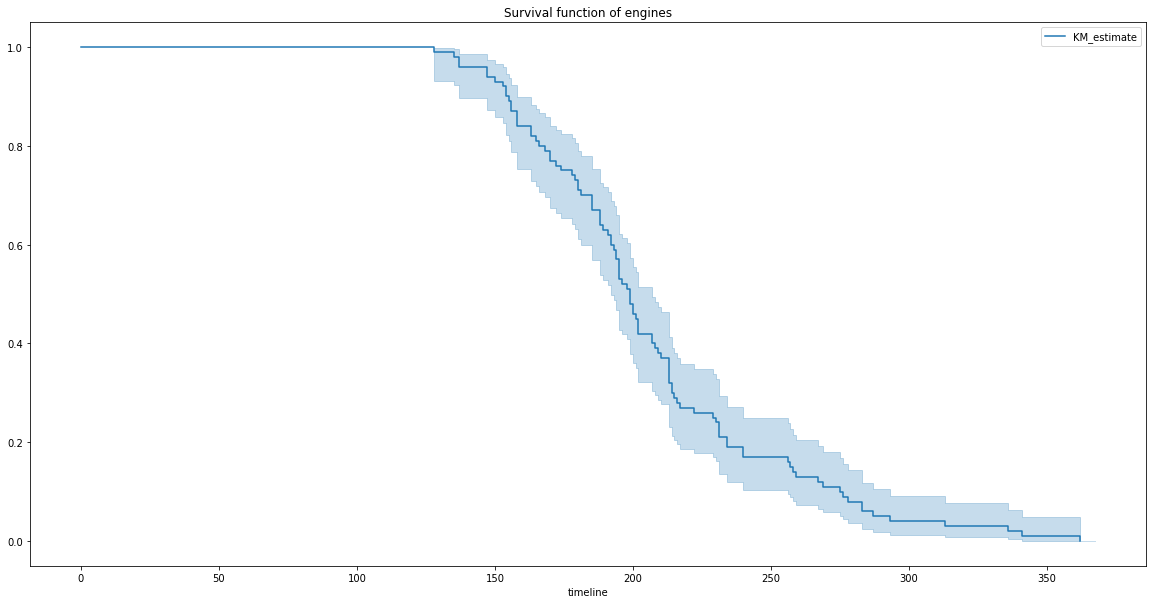

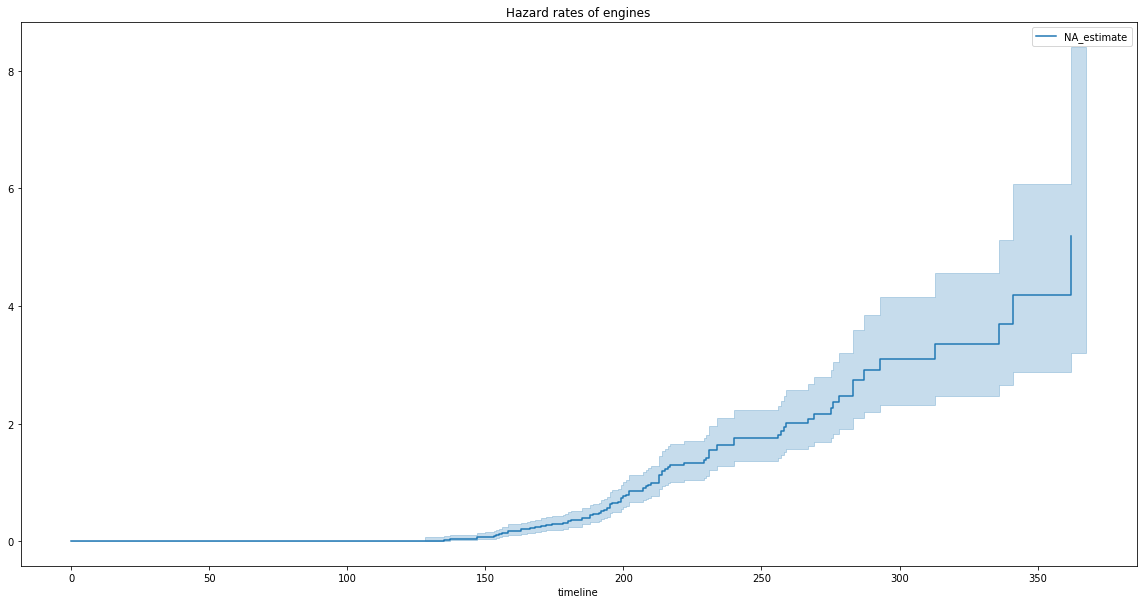

In [6]:
kmf = KaplanMeierFitter()
naf = NelsonAalenFitter()

kmf.fit(surv_time_df["T"], event_observed=surv_time_df["E"])
naf.fit(surv_time_df["T"], event_observed=surv_time_df["E"])

kmf.plot(figsize=(20, 10))
plt.title('Survival function of engines')

naf.plot(figsize=(20, 10))
plt.title('Hazard rates of engines')

print("Survival time median %d" % kmf.median_)

In [7]:
wf = WeibullFitter()
wf.fit(surv_time_df["T"], event_observed=surv_time_df["E"])
print(wf.lambda_, wf.rho_)
wf.print_summary()

0.004443934417403259 4.408715035932169
n=100, number of events=100

          coef  se(coef)  lower 0.95  upper 0.95
lambda_ 0.0044    0.0001      0.0042      0.0047
rho_    4.4087    0.3089      3.8033      5.0141


There are two popular competing techniques in survival regression: Cox’s model and Aalen’s additive model. Both models attempt to represent the hazard rate $\lambda(t|x)$ as a function of t and some covariates $x$. In Cox’s model, the relationship is defined:

$$\lambda(t | x) = b_0(t) \exp \left( b_1x_1 + ... + b_dx_d\right)$$

On the other hand, Aalen’s additive model assumes the following form:

$$\lambda(t | x) = b_0(t) + b_1(t)x_1 + ... + b_d(t)x_d$$

In [53]:
surv_reg_df = train_orig.copy()

surv_reg_df["T_min"] = surv_reg_df.groupby("Unit")["Time"].transform(lambda x: x.min())
surv_reg_df["T_max"] = surv_reg_df.groupby("Unit")["Time"].transform(lambda x: x.max())

surv_reg_df["T"] = surv_reg_df["Time"] - surv_reg_df["T_min"] + 1
surv_reg_df["E"] = surv_reg_df["Time"] == surv_reg_df["T_max"]

surv_reg_df.dropna(inplace=True)
surv_reg_df.describe()

,Unit,Time,Setting1,Setting2,Setting3,FanInletTemp,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,FanInletPres,...,BypassRatio,BurnerFuelAirRatio,BleedEnthalpy,DemandFanSpeed,DemandCorrFanSpeed,HPTCoolantBleed,LPTCoolantBleed,T_min,T_max,T
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,1.0,216.615724,108.807862
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251,0.0,50.028600,68.880990
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,1.0,128.000000,1.000000
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,1.0,185.000000,52.000000
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,1.0,207.000000,104.000000
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,1.0,240.000000,156.000000
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,1.0,362.000000,362.000000


In [54]:
surv_reg_df.drop(["Unit", "Time", "T_min", "T_max", 
                  'Setting1', 'Setting2', 'Setting3', 'FanInletTemp', 'FanInletPres',
                  'DemandFanSpeed', 'DemandCorrFanSpeed',
                  'BypassDuctPres', 'EnginePresRatio', 'BurnerFuelAirRatio'], axis=1, inplace=True)

In [55]:
surv_reg_df.corr()

,LPCOutletTemp,HPCOutletTemp,LPTOutletTemp,TotalHPCOutletPres,PhysFanSpeed,PhysCoreSpeed,StaticHPCOutletPres,FuelFlowRatio,CorrFanSpeed,CorrCoreSpeed,BypassRatio,BleedEnthalpy,HPTCoolantBleed,LPTCoolantBleed,T,E
LPCOutletTemp,1.000000,0.602610,0.714949,-0.702136,0.662325,0.273764,0.740020,-0.724578,0.661792,0.179752,0.675975,0.629886,-0.661841,-0.668050,0.549898,0.145273
HPCOutletTemp,0.602610,1.000000,0.678413,-0.664595,0.602481,0.322964,0.695900,-0.680307,0.600963,0.237137,0.639921,0.600017,-0.625941,-0.633901,0.543947,0.136324
LPTOutletTemp,0.714949,0.678413,1.000000,-0.793130,0.746852,0.297429,0.830136,-0.815591,0.745158,0.190748,0.758459,0.703499,-0.748067,-0.745193,0.624577,0.170121
TotalHPCOutletPres,-0.702136,-0.664595,-0.793130,1.000000,-0.767132,-0.217835,-0.822805,0.812713,-0.764611,-0.110053,-0.747051,-0.692893,0.736163,0.737447,-0.595914,-0.158180
PhysFanSpeed,0.662325,0.602481,0.746852,-0.767132,1.000000,-0.032091,0.782213,-0.786540,0.826084,-0.144787,0.700949,0.627785,-0.687030,-0.688840,0.475977,0.147132
PhysCoreSpeed,0.273764,0.322964,0.297429,-0.217835,-0.032091,1.000000,0.274591,-0.210238,-0.034763,0.963157,0.293753,0.337110,-0.285280,-0.292795,0.443999,0.107824
StaticHPCOutletPres,0.740020,0.695900,0.830136,-0.822805,0.782213,0.274591,1.000000,-0.846884,0.780761,0.163408,0.780913,0.722296,-0.771510,-0.772554,0.634385,0.166879
FuelFlowRatio,-0.724578,-0.680307,-0.815591,0.812713,-0.786540,-0.210238,-0.846884,1.000000,-0.788441,-0.098141,-0.766052,-0.703485,0.751943,0.756263,-0.611354,-0.164836
CorrFanSpeed,0.661792,0.600963,0.745158,-0.764611,0.826084,-0.034763,0.780761,-0.788441,1.000000,-0.147036,0.697662,0.627410,-0.686172,-0.688948,0.477523,0.151044
CorrCoreSpeed,0.179752,0.237137,0.190748,-0.110053,-0.144787,0.963157,0.163408,-0.098141,-0.147036,1.000000,0.193761,0.246621,-0.187364,-0.192415,0.370324,0.089166


In [56]:
surv_reg_df.drop(["PhysCoreSpeed", "CorrCoreSpeed"], axis=1, inplace=True)

n=20631, number of events=100

                       coef   exp(coef)  se(coef)       z      p  lower 0.95  upper 0.95     
LPCOutletTemp        0.4753      1.6085    0.3477  1.3669 0.1717     -0.2062      1.1568     
HPCOutletTemp        0.0468      1.0480    0.0265  1.7706 0.0766     -0.0050      0.0987    .
LPTOutletTemp        0.1660      1.1805    0.0274  6.0494 0.0000      0.1122      0.2197  ***
TotalHPCOutletPres  -0.2558      0.7743    0.2557 -1.0004 0.3171     -0.7569      0.2453     
PhysFanSpeed         3.2354     25.4166    2.7476  1.1775 0.2390     -2.1497      8.6205     
StaticHPCOutletPres  3.7041     40.6136    0.9256  4.0019 0.0001      1.8900      5.5182  ***
FuelFlowRatio       -0.6366      0.5291    0.2846 -2.2367 0.0253     -1.1945     -0.0788    *
CorrFanSpeed         2.4522     11.6142    2.6344  0.9309 0.3519     -2.7111      7.6155     
BypassRatio         11.7656 128751.9593    5.4656  2.1527 0.0313      1.0532     22.4781    *
BleedEnthalpy        0.4556  

Text(0.5,1,'Importance of regression variables')

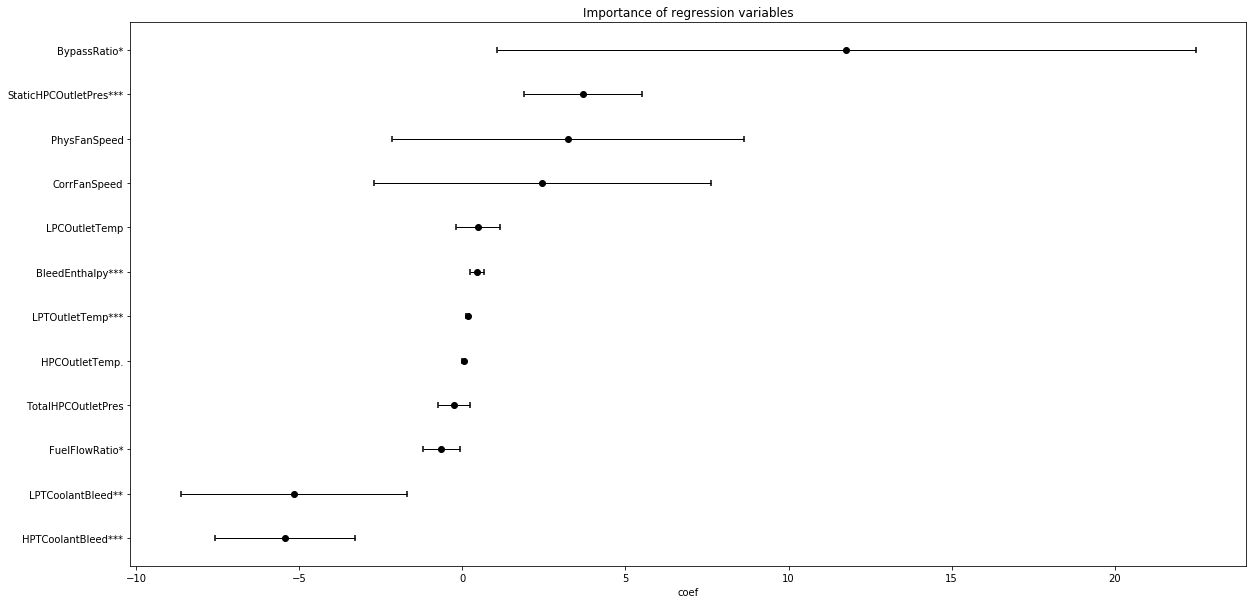

In [57]:
from lifelines import CoxPHFitter
cph = CoxPHFitter()

cph.fit(surv_reg_df, duration_col="T", event_col="E", show_progress=False)
cph.print_summary()

_, ax = plt.subplots(1, 1, figsize=(20, 10))
cph.plot(figsize=(20, 10), ax=ax)
ax.set_title("Importance of regression variables")

Text(0.5,1,'Survival scenario when varying $\\mathbf{LPTCoolantBleed}$')

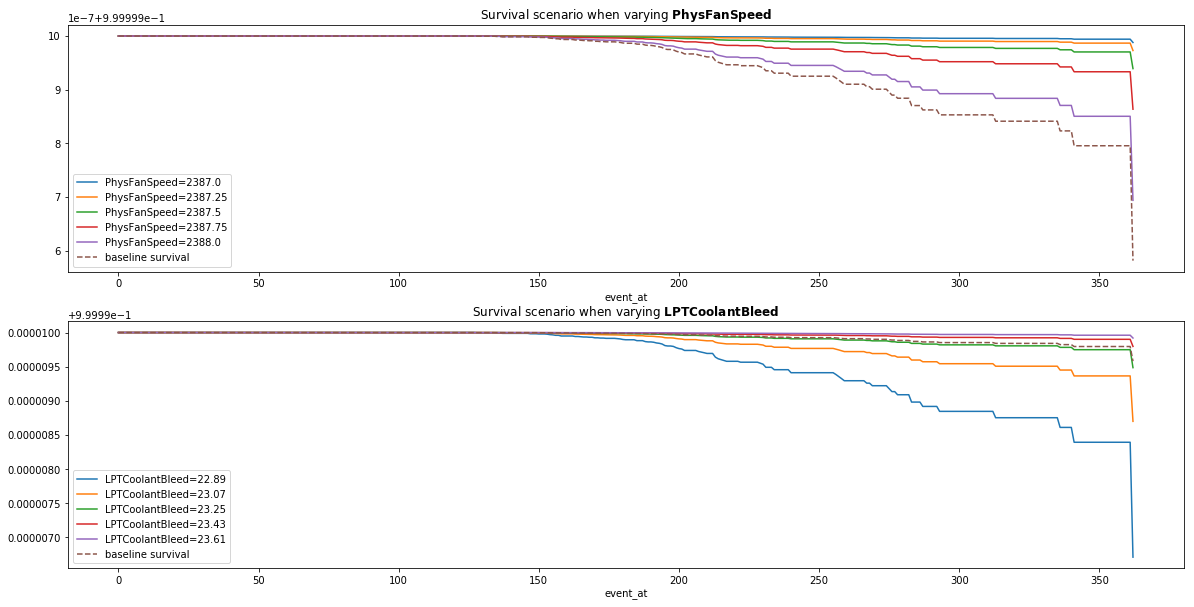

In [58]:
_, axs = plt.subplots(2, 1, figsize=(20, 10))
cph.plot_covariate_groups('PhysFanSpeed', [2387., 2387.25, 2387.5, 2387.75, 2388.], ax=axs[0])
axs[0].set_title("Survival scenario when varying $\mathbf{PhysFanSpeed}$")

cph.plot_covariate_groups('LPTCoolantBleed', np.linspace(22.89, 23.61, 5), ax=axs[1])
axs[1].set_title("Survival scenario when varying $\mathbf{LPTCoolantBleed}$")

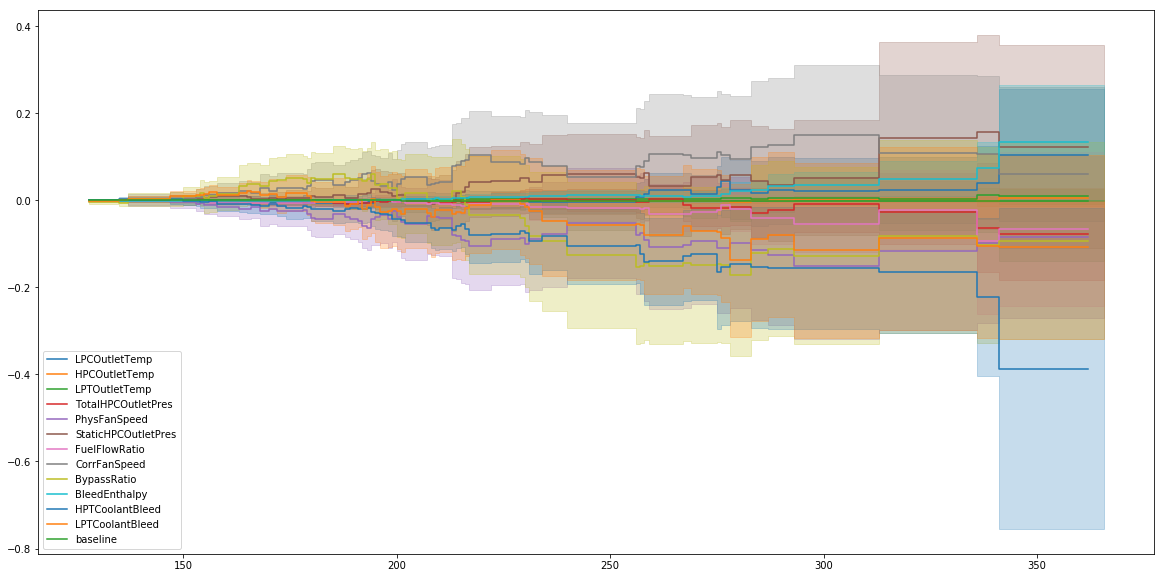

In [59]:
from lifelines import AalenAdditiveFitter
aaf = AalenAdditiveFitter(coef_penalizer=1.0)


aaf.fit(surv_reg_df, duration_col="T", event_col="E", show_progress=False)

_, ax = plt.subplots(1, 1, figsize=(20, 10))
aaf.plot(figsize=(20, 10), ax=ax)